In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import time
import seaborn as sb

In [2]:
# Set Pandas to display more columns as default
pd.options.display.max_columns=30

In [3]:
def read_data_from_pickle(file_name, sort = True, by_column = 'dim_user_gid'): 
    
    data = pd.read_pickle(file_name)
    data["dim_user_gid"].astype(int)

    print("\nA short summary of the uploaded file:")
    print("The data was loaded into a data-frame.")
    print("There are {} different rows, and {} different columns.".format(data.shape[0], data.shape[1]))
    print("There are {} unique values at the dim_user_gid column.".format(data['dim_user_gid'].nunique()))
    print("There are {} *nan* values at the dim_user_gid column.".format(data['dim_user_gid'].isnull().sum()))

    if sort:
        data = data.sort_values(by = ["dim_user_gid"])
        print("The data-frame was sorted by the dim_user_gid column.\n")
    
    return data

In [8]:
def find_users_in_both_data_and_target_frames(data_frame, target_frame, sort = True, by_column = 'dim_user_gid'):
    
    result = data_frame.join(target_frame.set_index('dim_user_gid'), how="inner")
    
    print("\nA short summary:")
    print("The target frame was merged with the historical data frame, and it includes *only* users that appears in both.")
    print("There are {} different rows, and {} different columns.".format(result.shape[0], result.shape[1]))
    print("There are {} *nan* values at the dim_user_gid column.".format((result.shape[0] - result['dim_user_gid'].count())))
    print("There are {} unique values at the dim_user_gid column.".format(result['dim_user_gid'].nunique()))
    
    result = result.drop_duplicates(subset=["dim_user_gid"], keep='last')
    if sort:
        result = result.sort_values(by = ['dim_user_gid'])
        
    print("\nKeeping only the last entry of each duplicate.\nThe end data frame has {} rows.".format(result.shape[0]))
    print("It was sorted by the dim_user_gid column.\n")
    
    return result

In [23]:
def hist_of_numerical_feature(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    plt.figure(figsize=figure_size)
    n, bins, patches = plt.hist(x, bins=n_bins, edgecolor='black')
    ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
    plt.xticks(ticks, np.ceil(ticks))
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_xticks()
    # using format string '{:.0f}' here but you can choose others
    plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)

    # Set x-axis label
    plt.xlabel(column, labelpad=20, size=16)
    plt.ylabel("Count", labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

In [27]:
def get_hist_info(x, n_bins): 
    
    n, bins, patches = plt.hist(x, bins=n_bins)
    plt.close()

    return n ,bins, patches

In [25]:
def plot_loglog_scale(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    counts, bins, patches = get_hist_info(x, n_bins)
    bins_center = [(patch._x0 + patch._x1)/2 for patch in patches]
    
    plt.figure(figsize=figure_size)
        
    plt.loglog(bins_center, counts, '.-')

    plt.xlabel('$log_{10}$' + '({}) '.format(column), labelpad=20, size=16)
    plt.ylabel('$log_{10}$ (counts) ', labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)
    
    plt.show()

In [29]:
def plot_data_by_index(data_frame, column, marker_size = 0.5, figure_size = (10, 6)): 
    
    plt.figure(figsize=figure_size)
    plt.plot(range(data_frame[column].shape[0]), data_frame[column], '.', markersize = marker_size)
    plt.xlabel('Index in Data', labelpad=20, size=16)
    plt.ylabel(column, labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

### Loading the Features

In [4]:
# # Data with 1 million users
# file_name = "Data/data_features_1_million_users_20220915.pkl"

# # Data with 5 million users
# file_name = "Data/data_features_5_million_users_20220915.pkl"

# Data with 5 million users that was cleaned in Part 1, and if the name suggests, may inlcude seniority 
# column as well
file_name = "Data/data_features_5_million_users_20220915_cleaned_with_Seniority.pkl"

In [5]:
data_for_clustering = read_data_from_pickle(file_name)
data_for_clustering.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 4985297 different rows, and 27 different columns.
There are 4985297 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



,dim_user_gid,est_seniority,top_platform,level,trstier,level_bracket,is_elite,is_vip,llrecency,Lifetime_Revenue_Net,Last_30D_Revenue_Net,Last_90D_Revenue_Net,Last_30D_Transactions,Last_30D_Gross_Sink,Last_90D_Gross_Sink,Last_30D_Login_days,Last_90D_Login_days,credits_balance_EOD,coins_balance_EOD,number_of_bingo_rounds,Life_Time_Login_Days,total_rounds_mode_1,total_rounds_mode_2,total_rounds_mode_3,total_rounds_mode_4,total_rounds_mode_5,total_rounds_mode_6
23899,261,3628,Apple,74.0,2.0,lv_40_79,0,0,4,0.0000,0.0,0.000,0,42.0,42.0,2,2,23992.0,989739.0,0,72,0,0,0,0,0,0
40151,288,3628,Google,77.0,1.0,lv_40_79,0,0,1,0.0000,0.0,0.000,0,0.0,0.0,6,17,591.0,129887.0,0,66,0,0,0,0,0,0
40152,312,3628,Google,97.0,1.0,lv_80_119,0,0,1,0.0000,0.0,0.000,0,16952.0,53355.0,29,89,279.0,485502.0,10,136,0,0,5,0,0,0
40153,376,3628,Google,126.0,3.0,lv_120_139,0,0,10,85.1555,0.0,10.493,0,0.0,2652.0,1,7,2278.0,2863137.0,0,306,0,0,0,0,0,0
68592,381,3628,Google,129.0,2.0,lv_120_139,0,0,1,110.9604,0.0,10.493,0,450.0,25135.0,10,36,5698.0,1277645.0,0,307,0,0,0,0,0,0
80781,388,3628,Apple,85.0,2.0,lv_80_119,0,0,121,3.8430,0.0,0.000,0,0.0,0.0,0,0,1414.0,4238.0,0,109,0,0,0,0,0,0
48277,391,3628,Web,243.0,2.0,lv_200plus,0,0,1,0.0000,0.0,0.000,0,11580.0,34815.0,30,90,4.0,4128.0,5,2480,5,0,0,0,0,0
3584,427,3628,Facebook,208.0,3.0,lv_200plus,0,0,1,0.0000,0.0,0.000,0,21180.0,238137.0,27,87,426.0,9904.0,5,1164,0,0,0,0,0,0
48278,436,3628,Facebook,72.0,2.0,lv_40_79,0,0,41,0.0000,0.0,0.000,0,0.0,772.0,0,1,204.0,342700.0,0,165,0,0,0,0,0,0
68593,454,3628,Google,64.0,2.0,lv_40_79,0,0,49,0.0000,0.0,0.000,0,0.0,1944.0,0,1,207.0,25913.0,0,66,0,0,0,0,0,0


### Loading the revenue target and initial data analysis

In [6]:
target_file_name = "Data/data_target_revenue_20220916.pkl"

In [10]:
data_target_revenue = read_data_from_pickle(target_file_name)
data_target_revenue.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 103211 different rows, and 2 different columns.
There are 51856 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



,dim_user_gid,revenue_converted_net
17184,600,2.9153
81484,1240,3.4930
85786,1307,0.6230
34537,1621,10.4930
72900,1788,6.2930
72899,1788,6.2930
72898,1788,6.2930
72897,1788,0.6930
72896,1788,10.4930
21602,2082,19.5930


In [13]:
# Calculating the total revenue of a given user (as a user might have had several purchase events in a day)
data_target_revenue['Total_revenue_at_day'] = data_target_revenue.groupby(['dim_user_gid'])['revenue_converted_net'].transform('sum').astype(float)

# Adding a column with the number of purchase events of a user
data_target_revenue['num_purchase_events_of_user'] = data_target_revenue.groupby('dim_user_gid')['dim_user_gid'].transform('size')

# Keeping just the information per a user id
data_target_revenue = data_target_revenue.drop_duplicates(subset=['dim_user_gid']).drop('revenue_converted_net', axis = 1)

data_target_revenue.head(10)

,dim_user_gid,Total_revenue_at_day,num_purchase_events_of_user
17184,600,2.9153,1
81484,1240,3.4930,1
85786,1307,0.6230,1
34537,1621,10.4930,1
72900,1788,30.0650,5
21602,2082,68.5510,7
47251,2115,19.5965,1
89753,2136,0.7184,1
94256,2295,59.5080,5
56186,2377,8.7777,1


In [16]:
print("The shape of the target data frame is:\n{}".format(data_target_revenue.shape))
print("\nAnd the types of the data is:")
print(data_target_revenue.dtypes)

The shape of the target data frame is:
(51856, 3)

And the types of the data is:
dim_user_gid                     int64
Total_revenue_at_day           float64
num_purchase_events_of_user      int64
dtype: object


In [19]:
column = "Total_revenue_at_day"
print("There are {} **zeros** and {} **nan** in the {} column".format(len(data_target_revenue[data_target_revenue['Total_revenue_at_day'] == 0]), data_target_revenue[column].isnull().sum(), column))

There are 0 **zeros** and 0 **nan** in the Total_revenue_at_day column


The revenue data set only includes paying users.   
So in the clustering, it is expected that this users will be at only a few clusters -> as the vast majority of the users in the general population are non-paying users. 

So I expect a low spread of target among the clusters that will include the non-paying users, and a high spread among the cluster(s) that will include the paying users. Unless the clustering is done on only paying users. 

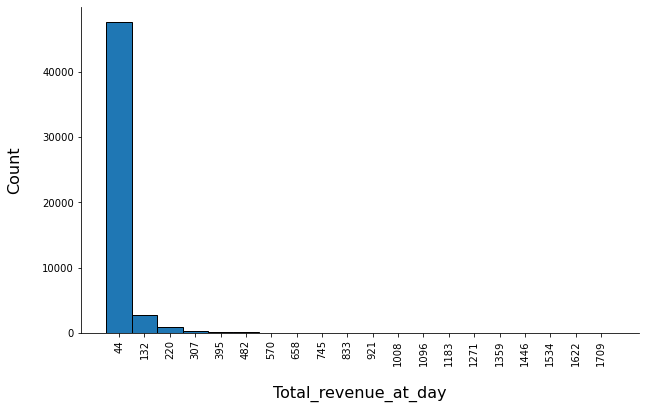

In [24]:
n_bins = 20
hist_of_numerical_feature(data_target_revenue, 'Total_revenue_at_day', n_bins)

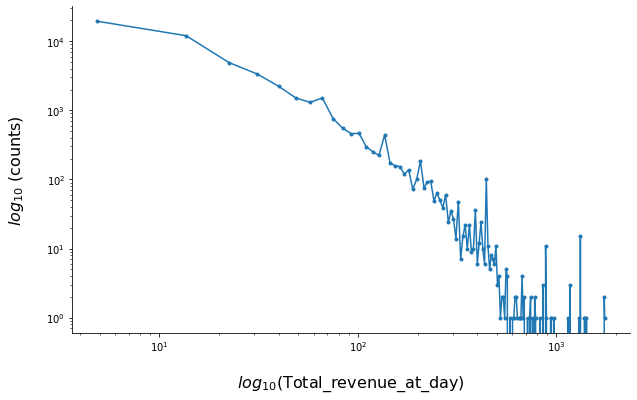

In [28]:
n_bins = 200
plot_loglog_scale(data_target_revenue, 'Total_revenue_at_day', n_bins)

The distribution of the revenue seems power-law even from a day of data. 

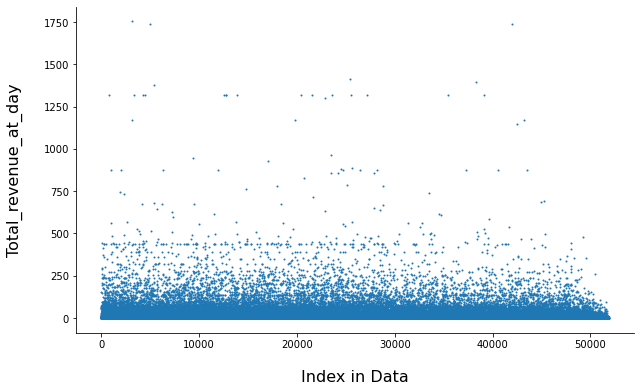


The lowest user id is: 600

and the highest user id is: 1004641327


In [33]:
marker_size = 2
plot_data_by_index(data_target_revenue, 'Total_revenue_at_day', marker_size)

print("\nThe lowest user id is: {}".format(data_target_revenue["dim_user_gid"].iloc[0]))
print("\nand the highest user id is: {}".format(data_target_revenue["dim_user_gid"].iloc[-1]))

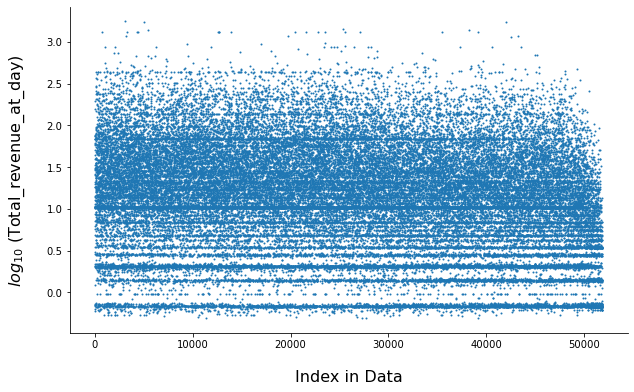

In [37]:
# And when the revenue is in log scale
plt.figure(figsize=(10,6))
plt.plot(range(data_target_revenue["dim_user_gid"].shape[0]), np.log10(data_target_revenue["Total_revenue_at_day"]), '.', markersize = marker_size)
plt.xlabel('Index in Data', labelpad=20, size=16)
plt.ylabel('$log_{10}$ (Total_revenue_at_day) ', labelpad=20, size=16)
sb.despine(top=True, right=True, left=False, bottom=False)

plt.show()

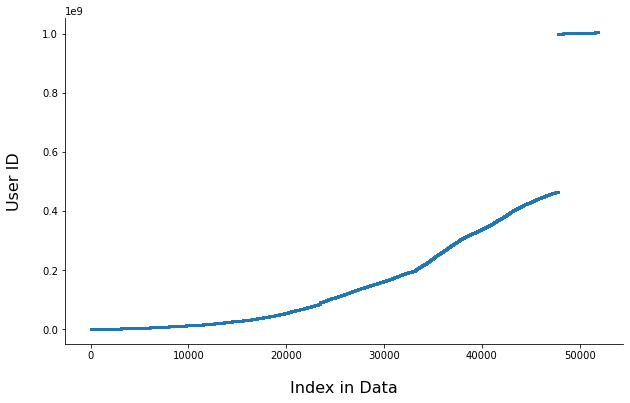

In [36]:
plt.figure(figsize=(10,6))
plt.plot(range(data_target_revenue["dim_user_gid"].shape[0]), data_target_revenue["dim_user_gid"], '.', markersize = marker_size)
plt.xlabel('Index in Data', labelpad=20, size=16)
plt.ylabel("User ID", labelpad=20, size=16)
sb.despine(top=True, right=True, left=False, bottom=False)

plt.show()

An initial analysis (part 1) suggests that the revenue depends on the seniority of the users. Here we see that although there exist a wide range of users IDs, which suggest a spread in seniority, the daily revenue seems independent of that (see figure in previous cell), at least up to the last group of users with very high numbers, that are seperated from the other users in this graph, and have lower average revenue in the above graph. 